In [1]:
import sys

import torch
import torch.nn as nn

sys.path.append("..")


In [2]:
from data.dataloader import LowLightDataModule
from model.blocks.homomorphic import HomomorphicSeparate
from model.blocks.singlestage import Encoder, Decoder
from utils.utils import show_batch, summarize_model


In [3]:
data_module = LowLightDataModule(
    train_dir="../data/1_train",
    valid_dir="../data/2_valid",
    bench_dir="../data/3_bench",
    infer_dir="../data/4_infer",
    image_size=128,
    batch_size=1,
    num_workers=4,
)

data_module.setup(stage="fit")


In [4]:
train_dataloader = data_module.train_dataloader()


torch.Size([1, 3, 128, 128])
torch.Size([1, 3, 128, 128])


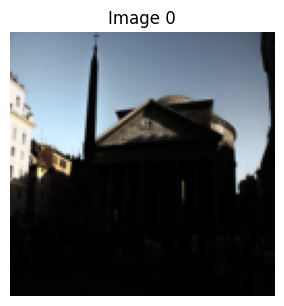

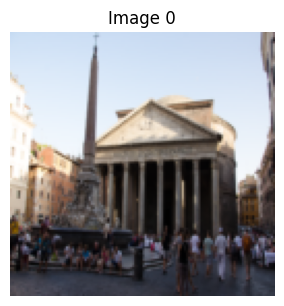

In [5]:
train_low, train_high = next(iter(train_dataloader))
print(train_low.shape)
print(train_high.shape)
show_batch(images=train_low)
show_batch(images=train_high)


In [6]:
separate = HomomorphicSeparate(cutoff=0.1)


In [7]:
train_low = train_low.cuda()
separate = separate.cuda()


In [8]:
x1, x2, x3 = train_low[:, 0:1, :, :], train_low[:, 1:2, :, :], train_low[:, 2:3, :, :]
x1_il, x1_re = separate(x1)
x2_il, x2_re = separate(x2)
x3_il, x3_re = separate(x3)


In [9]:
encoder = Encoder(
    in_channels=3,
    out_channels=3,
    embed_dim=32,
    num_heads=8,
    mlp_ratio=4,
    patch_size=16,
    dropout_ratio=0.2,
    cutoff=0.1,
)


In [10]:
train_low = train_low.cuda()
encoder = encoder.cuda()


In [11]:
condition = encoder(train_low)


torch.Size([1, 3, 128, 128])


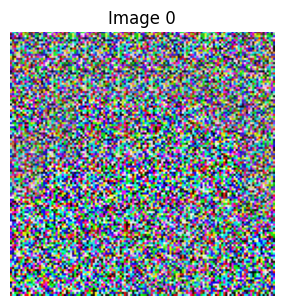

In [12]:
print(condition.shape)
show_batch(images=condition)


In [ ]:
summarize_model(encoder, (1, 3, 128, 128))


Layer (type:depth-idx)                   Output Shape              Param #
Encoder                                  [1, 3, 128, 128]          --
├─HomomorphicSeparate: 1-1               [1, 1, 128, 128]          --
├─HomomorphicSeparate: 1-2               [1, 1, 128, 128]          --
├─HomomorphicSeparate: 1-3               [1, 1, 128, 128]          --
├─PatchEmbedding: 1-4                    [1, 64, 32]               2,048
│    └─Conv2d: 2-1                       [1, 32, 8, 8]             24,576
│    └─Flatten: 2-2                      [1, 32, 64]               --
├─PatchEmbedding: 1-5                    [1, 64, 32]               (recursive)
│    └─Conv2d: 2-3                       [1, 32, 8, 8]             (recursive)
│    └─Flatten: 2-4                      [1, 32, 64]               --
├─SelfAttentionBlock: 1-6                [1, 64, 32]               --
│    └─SelfAttention: 2-5                [1, 64, 32]               --
│    │    └─LayerNorm: 3-1               [1, 64, 32]        

In [13]:
decoder = Decoder(
    in_channels=3,
    out_channels=3,
    embed_dim=32,
    num_heads=8,
    mlp_ratio=4,
    patch_size=16,
    dropout_ratio=0.2,
    num_resolution=2,
)


In [14]:
decoder = decoder.cuda()


In [ ]:
summarize_model(decoder, (1, 3, 128, 128))


RuntimeError: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: []

In [15]:
output = decoder(train_low, condition)


RuntimeError: Given groups=1, weight of size [64, 32, 4, 4], expected input[1, 1, 64, 32] to have 32 channels, but got 1 channels instead

In [ ]:
show_batch(images=output)
